In [1]:
import math
import numpy as np
import scipy.sparse as sp
from pmf import PoissonMF
import matplotlib.pyplot as plt

# Simulate data

Some users, which we call *gaming users*, would like certain notes to appear on the platform, and they coordinate with each other to upvote these notes together.

We simulate this scenario as follows:
- There are $m=1000$ users and $n=1000$ notes. 
- $p_{\text{gaming}}^{\text{user}}=0.25$ proportion of users are gaming users
- Gaming users care about a proportion $p_{\text{gaming}}^{\text{item}}=0.1$ of notes

The latent factors for a note $i$ are
- Let $g_i$ be whether a note is of interest to gaming users: $g_i \sim \text{Bern}(p_{\text{gaming}}^{\text{item}})$
- The item also has other latent factors related to exposure: $\alpha^{\text{exp}}_i \sim \text{Gamma}_{K-1}(0.3, 0.3)$. The full item latent factor is $\beta^{\text{exp}}_i = [g_i, \alpha_{i1}, \alpha_{i2}, \dots, \alpha_{i(k-1)}]$
- The item has latent factors related to the actual observed ratings: $\theta^{\text{rating}}_i \sim \text{Gamma}_{K}(0.3, 0.3)$

The probability $a_{ui}$ that a user $u$ rates a note $i$ is defined by the following:
- A gaming user $u$'s probability of rating a note $i$ is $a_{ui} \sim \text{Bern}(q \cdot g_i)$
  - $g_i$ is whether a note is of interest to gaming users: $g_i \sim \text{Bern}(p_{\text{gaming}}^{\text{item}})$
  - $q = 0.75$ is how likely a gaming user is to rate a note, given that is a note of interest
- A non-gaming user $u$'s probability of rating a note $i$ is $a_{ui} \sim \min(\text{Poisson}(\theta_u^T \beta_i), 1)$
  - $\theta_u \sim \text{Gamma}_{K}(0.3, 0.3)$ and $\beta_i \sim \text{Gamma}_{K}(0.3, 0.3)$

The observed rating $r_{ui}$ is defined by the following:
- For a gaming user, $r_{ui} = a_{ui}$ (the gaming users always up-vote the notes of interest to them)
- For a non-gaming user, $r_{ui} \sim \min(\text{Poisson}(\lambda_u^T \alpha_i)-1, 1)$ 
  - $\theta_u \sim \text{Gamma}_{K}(0.6, 0.6)$ and $\beta_i \sim \text{Gamma}_{K}(0.6, 0.6)$

## Simulate exposure matrix

In [2]:
K = 10 # Num latent factors
num_users = 1000
num_items = 1000
pct_users_gaming = 0.25
num_gaming_users = int(num_users * pct_users_gaming)
num_normal_users = num_users - num_gaming_users

## Generate latent item factors
# First, generate whether the item is one that gaming users care about
pct_items_gaming_users_care_about = 0.1
gamed_item = np.random.binomial(1, pct_items_gaming_users_care_about, size=(num_items, 1))
# Then, generate other latent factors
item_factors = np.random.gamma(0.3, 0.3, size=(num_items, K))

## Exposures for gaming users
prob_gaming_user_rates_rel_item = 0.75 # prob a gaming user rates an item they care about
probs = (gamed_item*prob_gaming_user_rates_rel_item)[:,0]
exposures_gaming = np.random.binomial(
    1, probs, 
    size=(num_gaming_users, num_items))
sparsity_gaming = np.sum(exposures_gaming)/num_gaming_users/num_items
print(f'Pct ratings (non-gaming users): {sparsity_gaming}')


## Exposures for non-gaming users
exp_user_factors = np.random.gamma(0.3, 0.3, size=(num_normal_users, K))
exp_scores = exp_user_factors @ item_factors.T
exposures_nongamimg= np.random.poisson(exp_scores)
exposures_nongamimg = np.minimum(exposures_nongamimg, 1)
sparsity_nongaming = np.sum(exposures_nongamimg)/num_normal_users/num_items
print(f'Pct ratings (non-gaming users): {sparsity_nongaming}')

# Combine exposures of gaming and non-gaming users
exposures = np.concatenate([exposures_gaming, exposures_nongamimg])

Pct ratings (non-gaming users): 0.062908
Pct ratings (non-gaming users): 0.07256933333333333


## Simulate ratings matrix

In [3]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

In [4]:
# Gamers are upvoting the ones that they rate
ratings_gaming = np.ones_like(exposures_gaming)*exposures_gaming
# Non-gamers
user_factors = np.random.gamma(0.6, 0.6, size=(num_normal_users, K))
item_factors = np.random.gamma(0.6, 0.6, size=(num_items, K))
ratings_nongaming = user_factors @ item_factors.T
ratings_nongaming = np.minimum(np.random.poisson(ratings_nongaming) - 1, 1)
ratings_nongaming = ratings_nongaming
ratings = np.concatenate([ratings_gaming, ratings_nongaming])
ratings_obs = ratings * exposures

In [5]:
print(np.sum(ratings==-1))
print(np.sum(ratings==0))
print(np.sum(ratings==1))

283092
452961
263947


If we just rated notes by the mean of the observed ratings, then the gaming users would be very successful at getting their notes to the top.

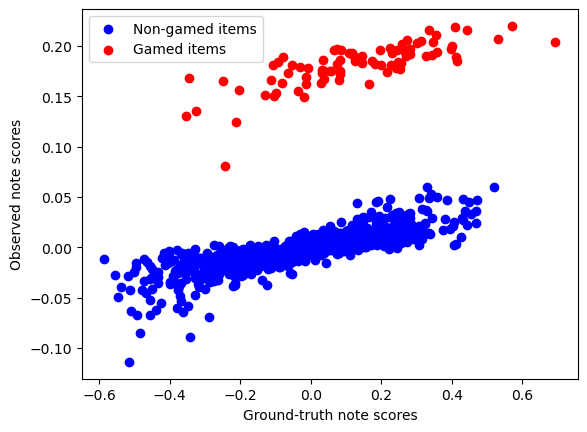

In [6]:
gt_scores = np.mean(ratings, axis=0)
obs_scores = np.mean(ratings_obs, axis=0)
gamed_item = gamed_item[:,0]
plt.scatter(gt_scores[gamed_item==0], obs_scores[gamed_item==0], color='blue', label='Non-gamed items')
plt.scatter(gt_scores[gamed_item==1], obs_scores[gamed_item==1], color='red', label='Gamed items')
plt.xlabel('Ground-truth note scores')
plt.ylabel('Observed note scores')
plt.legend()

# Fit model

## Fit PMF to exposure matrix

In [7]:
exposures_scr = sp.csr_matrix(exposures)
user_ids, item_ids = exposures_scr.nonzero()
pmf = PoissonMF(n_components=2, random_state=1, verbose=True, a=0.3, b=0.3, c=0.3, d=0.3)
pmf.fit(exposures_scr, user_ids, item_ids)

PoissonMF(n_components=2, random_state=1, verbose=True)

In [8]:
# Latent representations learned by Poisson MF
pmf_user_factors, pmf_item_factors = pmf.Eb, pmf.Et.T

In [9]:
gaming_users = pmf_user_factors[:num_gaming_users]
non_gaming_users = pmf_item_factors[num_gaming_users:]
print(gaming_users.mean(axis=0))
print(non_gaming_users.mean(axis=0))

[1.2378687  0.00421149]
[0.05246881 0.07119092]


Text(0.5, 1.0, 'Latent representations of users learned by Poisson MF')

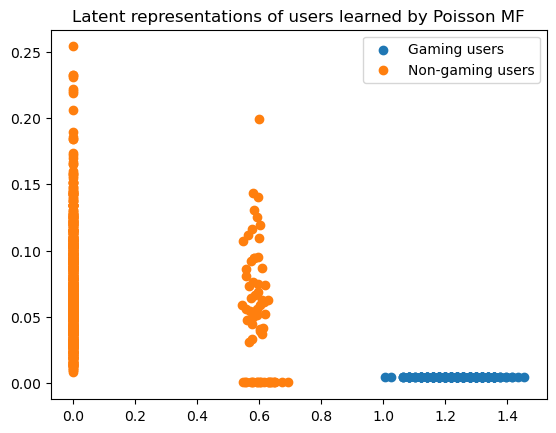

In [10]:
plt.scatter(gaming_users[:, 0], gaming_users[:, 1], label='Gaming users')
plt.scatter(non_gaming_users[:, 0], non_gaming_users[:, 1], label='Non-gaming users')
plt.legend()
plt.title('Latent representations of users learned by Poisson MF')

## Fit MF to ratings matrix

In [11]:
%load_ext autoreload
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch import nn
from mf import MatrixFactorizationModel, ModelData

In [12]:
# Our full model that deconfounds with the substitute confounder from step 1a
deconf_mf_model = MatrixFactorizationModel(
    num_users, num_items, 
    exp_user_factors=pmf_user_factors, exp_item_factors=pmf_item_factors,
    n_components=4)

# Regular matrix factorization without deconfounding
mf_model = MatrixFactorizationModel(num_users, num_items, n_components=4)

rating_labels = ratings_obs[user_ids, item_ids]
rating_tensor = torch.FloatTensor(rating_labels).to(deconf_mf_model.device)
user_idxs_tensor = torch.LongTensor(user_ids).to(deconf_mf_model.device)
note_idxs_tensor = torch.LongTensor(item_ids).to(deconf_mf_model.device)
exp_tensor = torch.ones_like(rating_tensor).to(deconf_mf_model.device)

data = ModelData(rating_tensor, user_idxs_tensor, note_idxs_tensor, exp_tensor)

In [13]:
train_loss, val_loss = deconf_mf_model.fit(data, epochs=150, lr=0.1, print_interval=20, validate_fraction=0.1, print_loss=True)

Epoch 0: train L2-reg loss = 0.387, val L2-reg loss = 0.745
Epoch 0: train MSE = 0.743, val MSE = 0.742
Epoch 20: train L2-reg loss = 0.231, val L2-reg loss = 0.527
Epoch 20: train MSE = 0.386, val MSE = 0.491
Epoch 40: train L2-reg loss = 0.221, val L2-reg loss = 0.524
Epoch 40: train MSE = 0.370, val MSE = 0.488
Epoch 60: train L2-reg loss = 0.219, val L2-reg loss = 0.524
Epoch 60: train MSE = 0.367, val MSE = 0.488
Epoch 80: train L2-reg loss = 0.219, val L2-reg loss = 0.524
Epoch 80: train MSE = 0.366, val MSE = 0.489
Epoch 100: train L2-reg loss = 0.218, val L2-reg loss = 0.524
Epoch 100: train MSE = 0.365, val MSE = 0.488
Epoch 120: train L2-reg loss = 0.218, val L2-reg loss = 0.523
Epoch 120: train MSE = 0.364, val MSE = 0.488
Epoch 140: train L2-reg loss = 0.218, val L2-reg loss = 0.523
Epoch 140: train MSE = 0.364, val MSE = 0.487


In [14]:
train_loss, val_loss = mf_model.fit(data, epochs=150, lr=0.1, print_interval=20, validate_fraction=0.1, print_loss=True)

Epoch 0: train L2-reg loss = 0.387, val L2-reg loss = 0.746
Epoch 0: train MSE = 0.744, val MSE = 0.744
Epoch 20: train L2-reg loss = 0.262, val L2-reg loss = 0.514
Epoch 20: train MSE = 0.432, val MSE = 0.493
Epoch 40: train L2-reg loss = 0.256, val L2-reg loss = 0.508
Epoch 40: train MSE = 0.430, val MSE = 0.488
Epoch 60: train L2-reg loss = 0.256, val L2-reg loss = 0.505
Epoch 60: train MSE = 0.428, val MSE = 0.485
Epoch 80: train L2-reg loss = 0.255, val L2-reg loss = 0.507
Epoch 80: train MSE = 0.428, val MSE = 0.487
Epoch 100: train L2-reg loss = 0.255, val L2-reg loss = 0.506
Epoch 100: train MSE = 0.428, val MSE = 0.486
Epoch 120: train L2-reg loss = 0.255, val L2-reg loss = 0.506
Epoch 120: train MSE = 0.428, val MSE = 0.487
Epoch 140: train L2-reg loss = 0.255, val L2-reg loss = 0.506
Epoch 140: train MSE = 0.428, val MSE = 0.486


## Voting aggregation

In [15]:
note_scores = mf_model.get_vote_scores(torch.mean)
deconf_note_scores = deconf_mf_model.get_vote_scores(torch.mean)

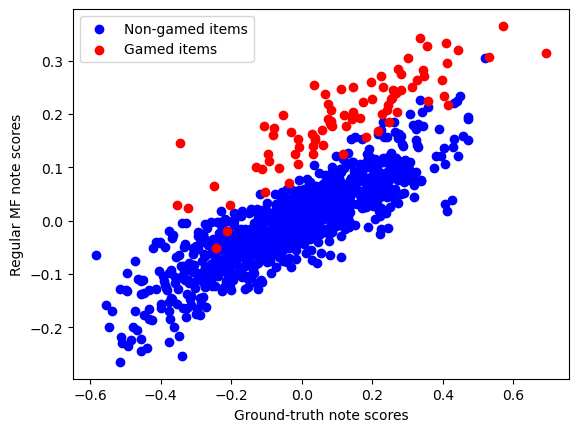

In [16]:
plt.scatter(gt_scores[gamed_item==0], note_scores[gamed_item==0], color='blue', label='Non-gamed items')
plt.scatter(gt_scores[gamed_item==1], note_scores[gamed_item==1], color='red', label='Gamed items')
plt.xlabel('Ground-truth note scores')
plt.ylabel('Regular MF note scores')
plt.legend()

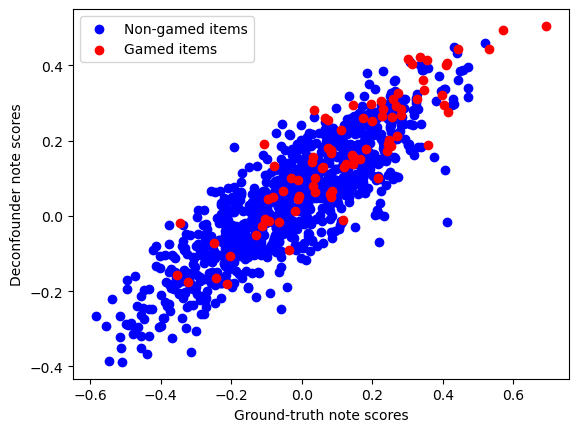

In [17]:
plt.scatter(gt_scores[gamed_item==0], deconf_note_scores[gamed_item==0], color='blue', label='Non-gamed items')
plt.scatter(gt_scores[gamed_item==1], deconf_note_scores[gamed_item==1], color='red', label='Gamed items')
plt.xlabel('Ground-truth note scores')
plt.ylabel('Deconfounder note scores')
plt.legend()